# We have the problem that wind forcing seems to dominate changes to modal decomposition, rather than topo shape!

## In this notebook, compare the same time slices over 100hr average. Focus on mode 1. Make movies maybe?

In [ ]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43013 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:34941' processes=7 threads=28, memory=112.00 GiB>


<Client: 'tcp://127.0.0.1:34941' processes=7 threads=28, memory=112.00 GiB>

2024-06-19 16:33:24,808 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:46037' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('rechunk-merge-d4bd12fce0dd8607b40944f84bce4d01', 0, 3, 0, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 3, 0, 2, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 3, 0, 1, 0), ('rechunk-merge-7a97c4e85cc0842101f3266826a33401', 0, 6, 0, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 7, 0, 3, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 6, 0, 0, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 0, 0, 4, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 9, 0, 3, 0), ('rechunk-merge-ea29e6546d598498e67d75fba00bd9a0', 0, 2, 0, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 7, 0, 2, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 6, 0, 2, 0), ('rechunk-merge-6307f403f199d2412f5b4ac282fcfa9e', 6, 0, 4, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915

## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [11]:
trange = 50
to_process = {
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    "blank-20": {
        "data":tt.collect_data(
            exptname="blank-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50))
    },
    "ideal-20": {
        "data":tt.collect_data(
            exptname="ideal-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50)),
    },
    "smooth-20": {
        "data":tt.collect_data(
            exptname="smooth-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    }

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118644285.gadi-pbs/ipykernel_1706308/1335473955.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


loading rho...	done.
loading u...	done.
loading v...	done.
loading rho...	done.
loading u...	done.
loading v...	done.
Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118644285.gadi-pbs/ipykernel_1706308/1335473955.py:29: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


In [36]:
## Redefine vertical modes. Expect data to include u and v.

def VerticalModes(data,zrange = slice(None,None),nmodes = 5):
    """
    Use Sturm-Liouville theory to calculate the vertical modes of the data. This is done by solving the eigenvalue problem
    
    input:
    data : xarray.Dataset
        The data to be used to calculate the vertical modes. Should include rho and bathymetry! So same as when you load from tt.collect_data
    var : str

    returns:
        Dataset with 'vrtl' and 'hztl' components of the vertical decomp.
    
    """
    data["H"] = np.abs(data.bathy)
    if "time" in data.rho.dims:
        data["N"] = tt.calculate_N(data.rho).rename("N").mean("time")
    else:
        data["N"] = tt.calculate_N(data.rho).rename("N")

    # data["N"] = np.linspace(data.N[0],data.N[-1],len(data["N"]))
    zl = data.zl.values
    def scipy_integrate(data):
        # print(data)
        return (data * 0) + scipy.integrate.cumulative_trapezoid(
            data,
            x = zl,
            initial = 0
            )


    # Use np.apply_along_axis to prevent averaging over N and H!
    eigenvectors = (data["rho"].isel(time = 0) * 0).expand_dims({"mode":nmodes})
    uout = (data["rho"].isel(zl = 0) * 0).expand_dims({"mode":nmodes})
    vout = (data["rho"].isel(zl = 0) * 0).expand_dims({"mode":nmodes}) 
    Nbar = data.N.integrate("zl") / data.H

    for n in range(1,nmodes + 1): ## Start from 1 or else your first eigenfunction only depends on N!
        
        to_integrate = (n * data["N"] * np.pi) / (data.H * Nbar)
        integrated =  np.apply_along_axis(scipy_integrate,0,to_integrate)
        phi_n = (np.sqrt(
            2 * data.N / (data.H * Nbar)
        ) * np.cos(
            integrated
        )).fillna(0)
        eigenvectors[n-1,:,:,:] = phi_n

        uout[n - 1,:,:,:] = (data.u.fillna(0) * phi_n).sel(zl = zrange).integrate("zl")
        vout[n - 1,:,:,:] = (data.v.fillna(0) * phi_n).sel(zl = zrange).integrate("zl")

    return xr.merge([uout.rename("u"),vout.rename("v"),eigenvectors.rename("phi")])

vmodes = VerticalModes(to_process["full-20"]["data"])

In [50]:
vmodes = vmodes.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 36.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


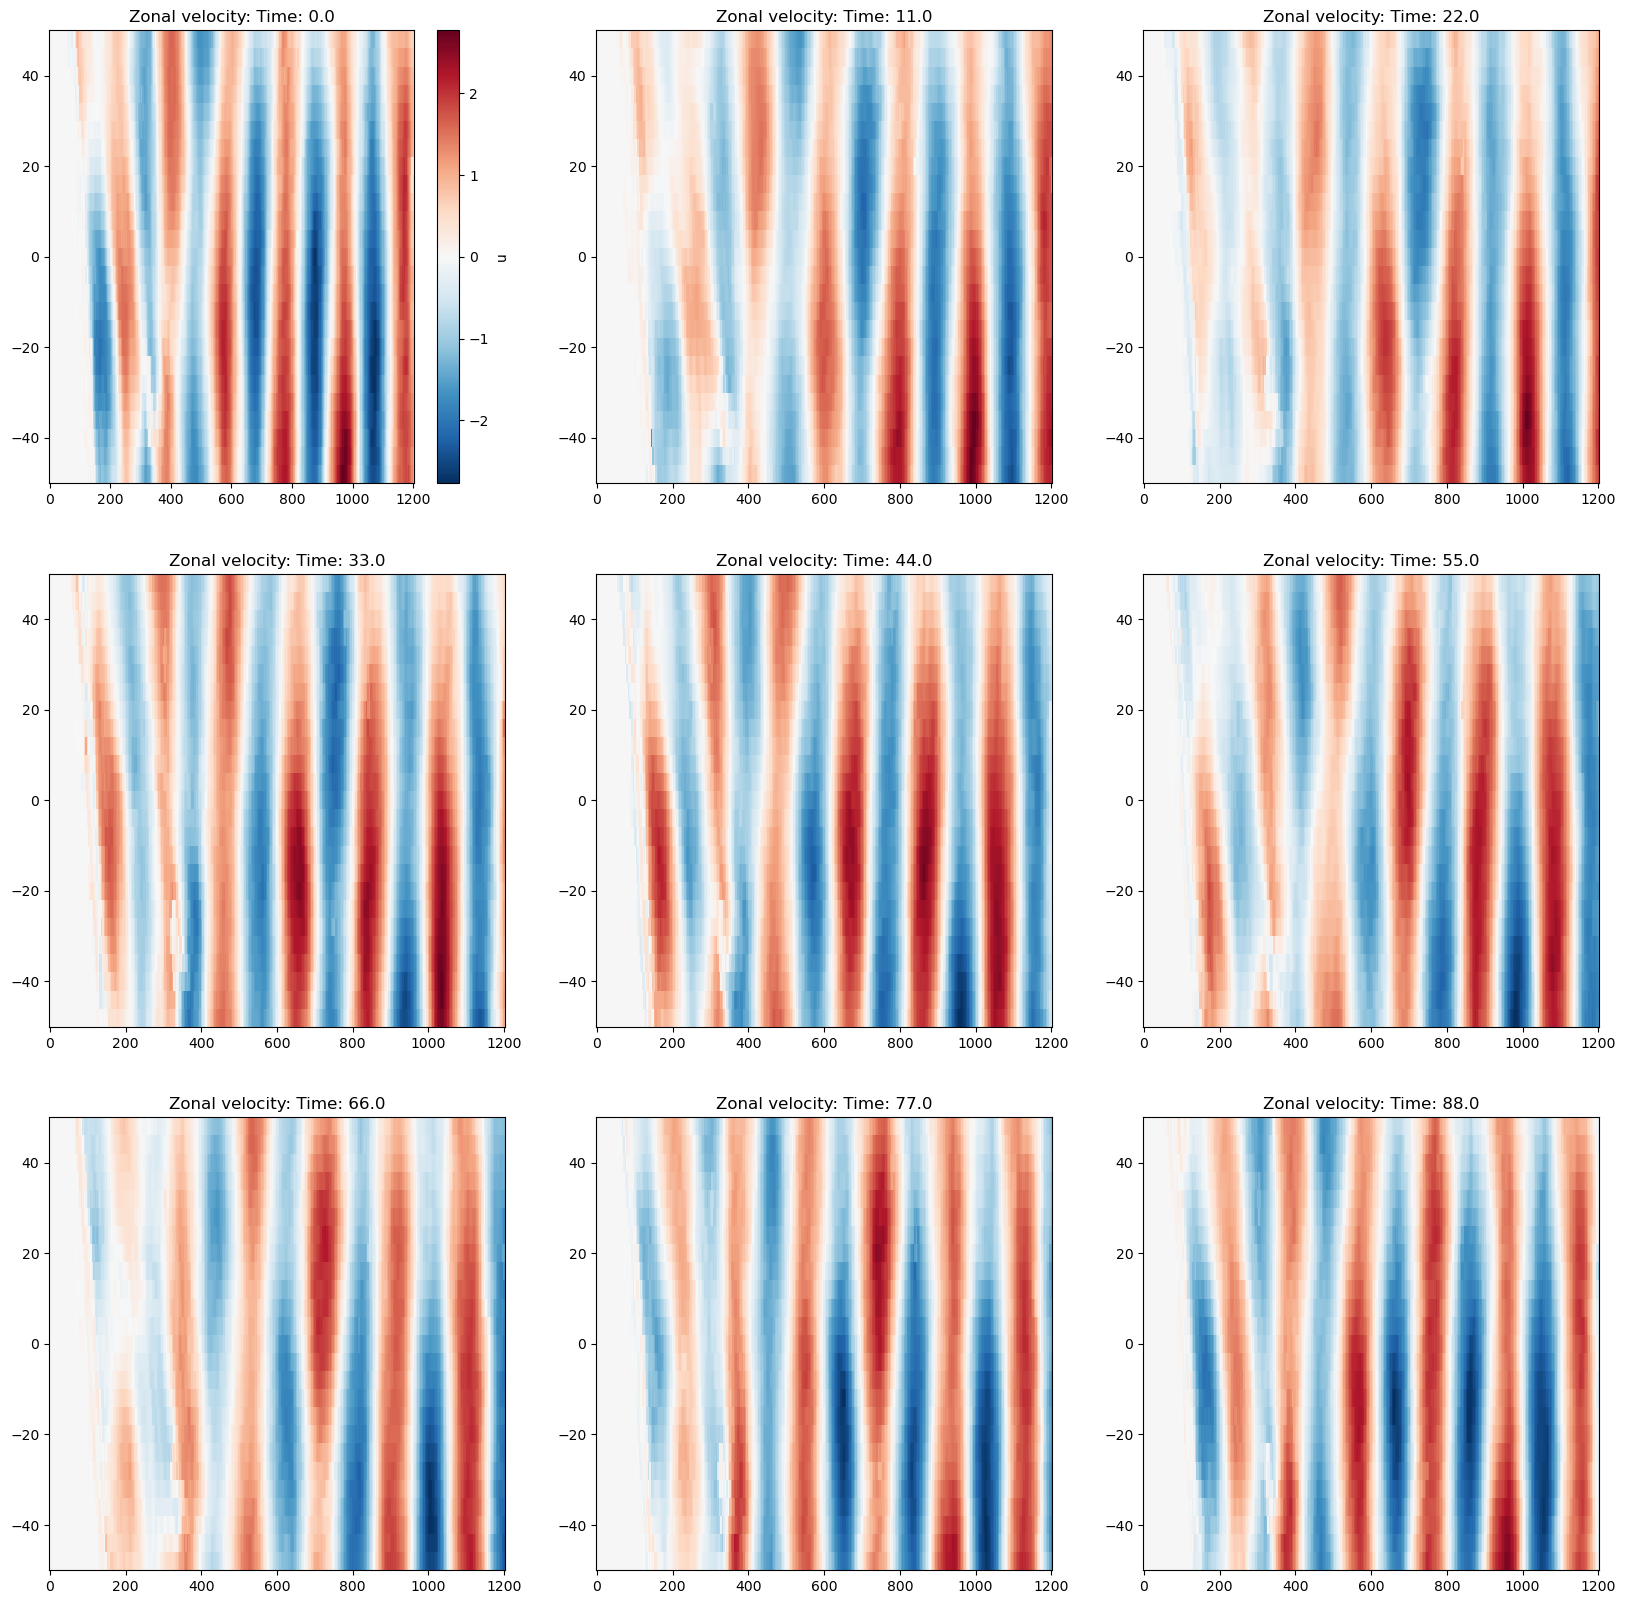

2024-06-19 16:33:25,516 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 452, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 431, in retry


In [66]:
## Make a 3 by 3 grid of plots that increases in time selection as you read top left to bottom right
fig,ax = plt.subplots(3,3,figsize = (20,20))
times = np.linspace(0,99,10)
for i in range(3):
    for j in range(3):
        if i == 0 and j == 0:
            vmodes.u.isel(time = int(times[i * 3 + j]),mode = 0).sel(xb = slice(0,1200)).plot(ax = ax[i,j],add_colorbar = True)
        else:
            vmodes.u.isel(time = int(times[i * 3 + j]),mode = 0).sel(xb = slice(0,1200)).plot(ax = ax[i,j],add_colorbar = False)
        ax[i,j].set_title(f"Zonal velocity: Time: {times[i * 3 + j]}")
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")



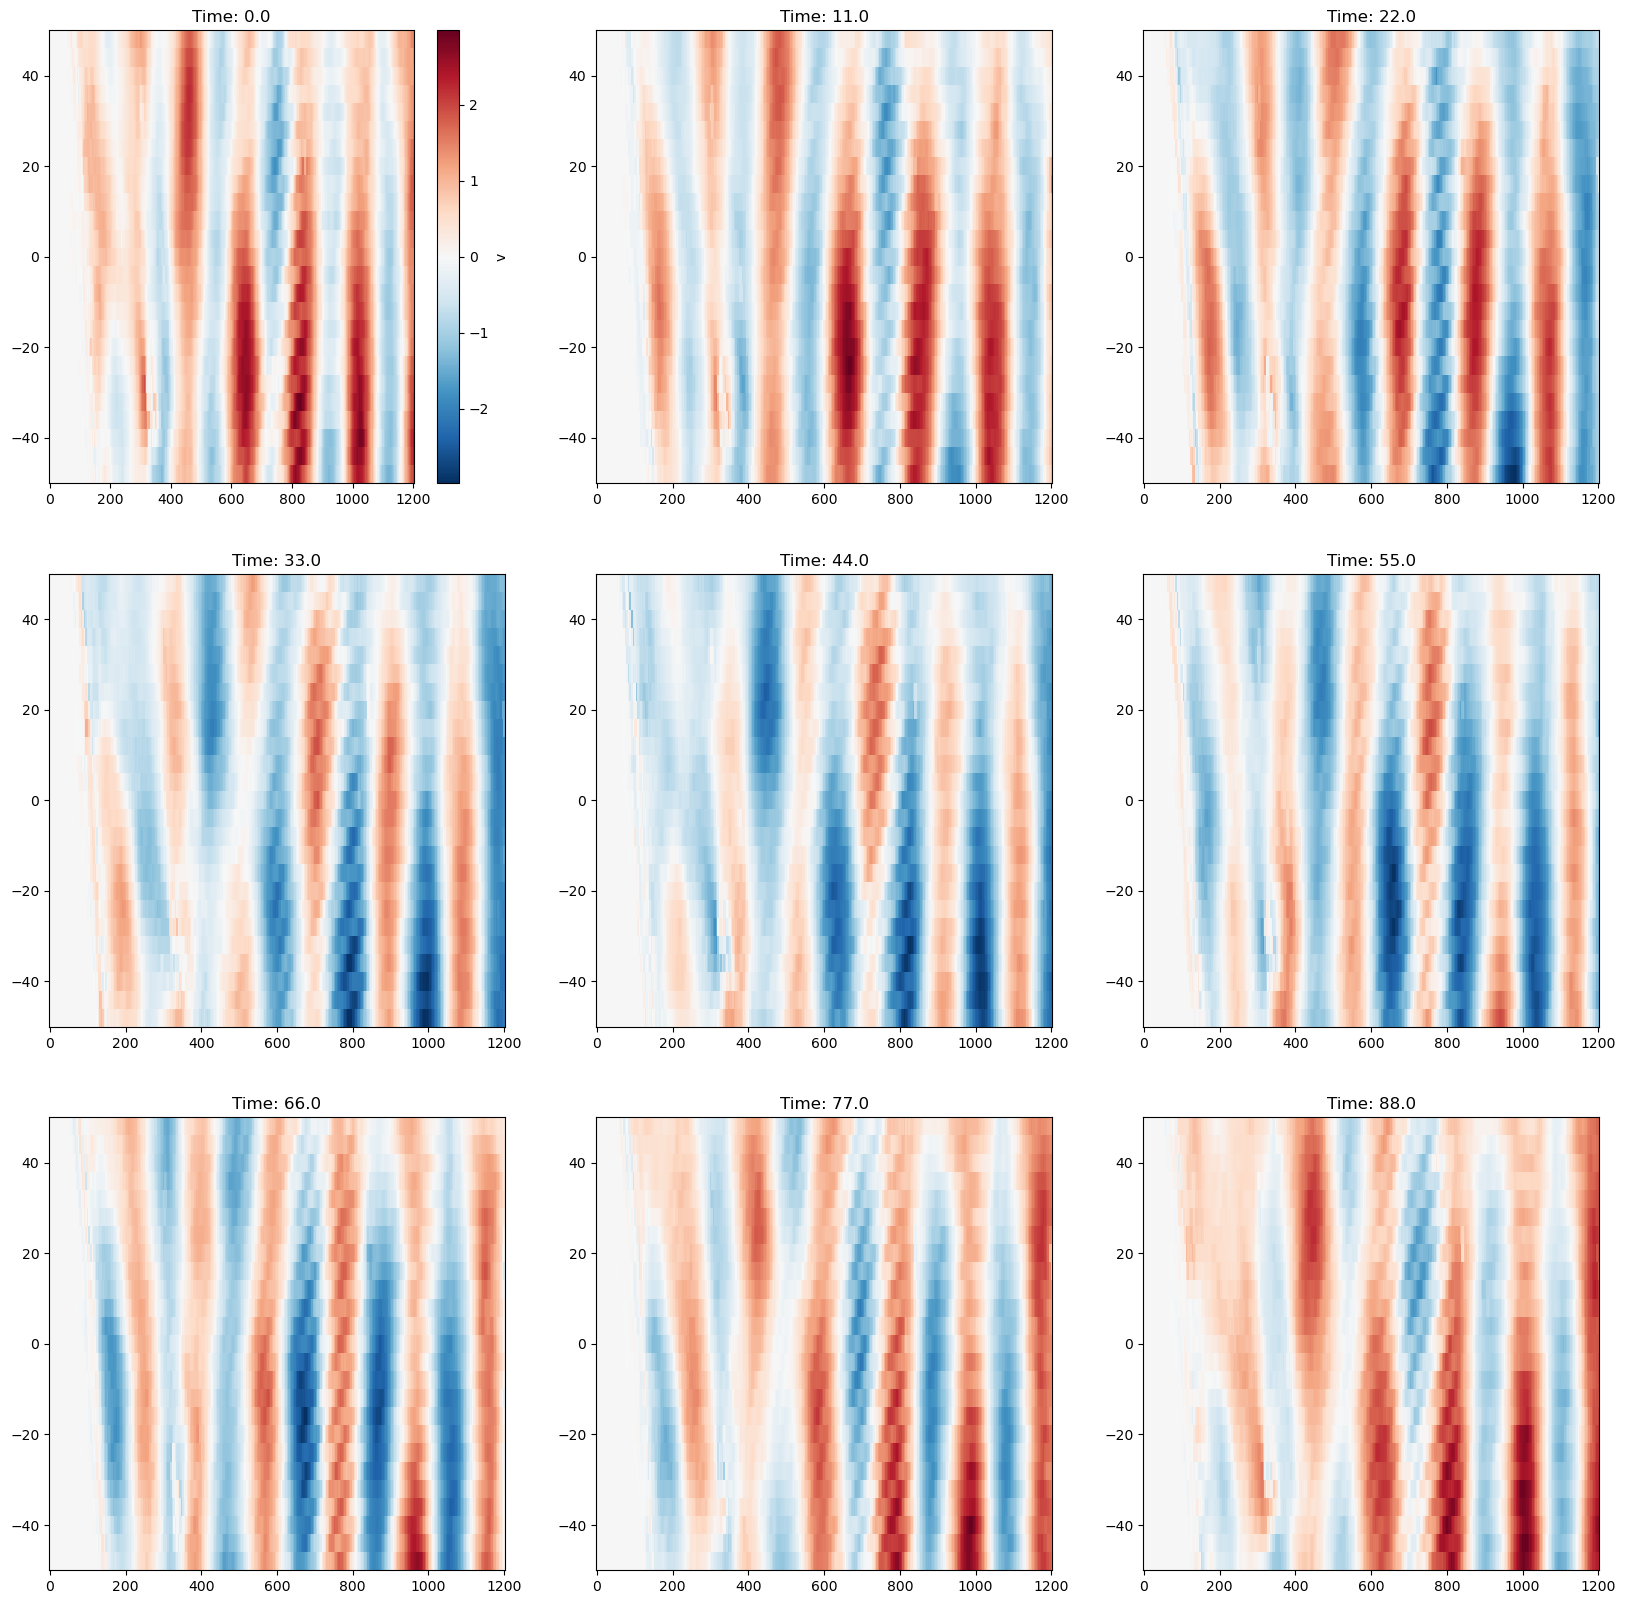

In [65]:
## Make a 3 by 3 grid of plots that increases in time selection as you read top left to bottom right
fig,ax = plt.subplots(3,3,figsize = (20,20))
times = np.linspace(0,99,10)
for i in range(3):
    for j in range(3):
        if i == 0 and j == 0:
            vmodes.v.isel(time = int(times[i * 3 + j]),mode = 0).sel(xb = slice(0,1200)).plot(ax = ax[i,j],add_colorbar = True)
        else:
            vmodes.v.isel(time = int(times[i * 3 + j]),mode = 0).sel(xb = slice(0,1200)).plot(ax = ax[i,j],add_colorbar = False)
        ax[i,j].set_title(f"Time: {times[i * 3 + j]}")
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")



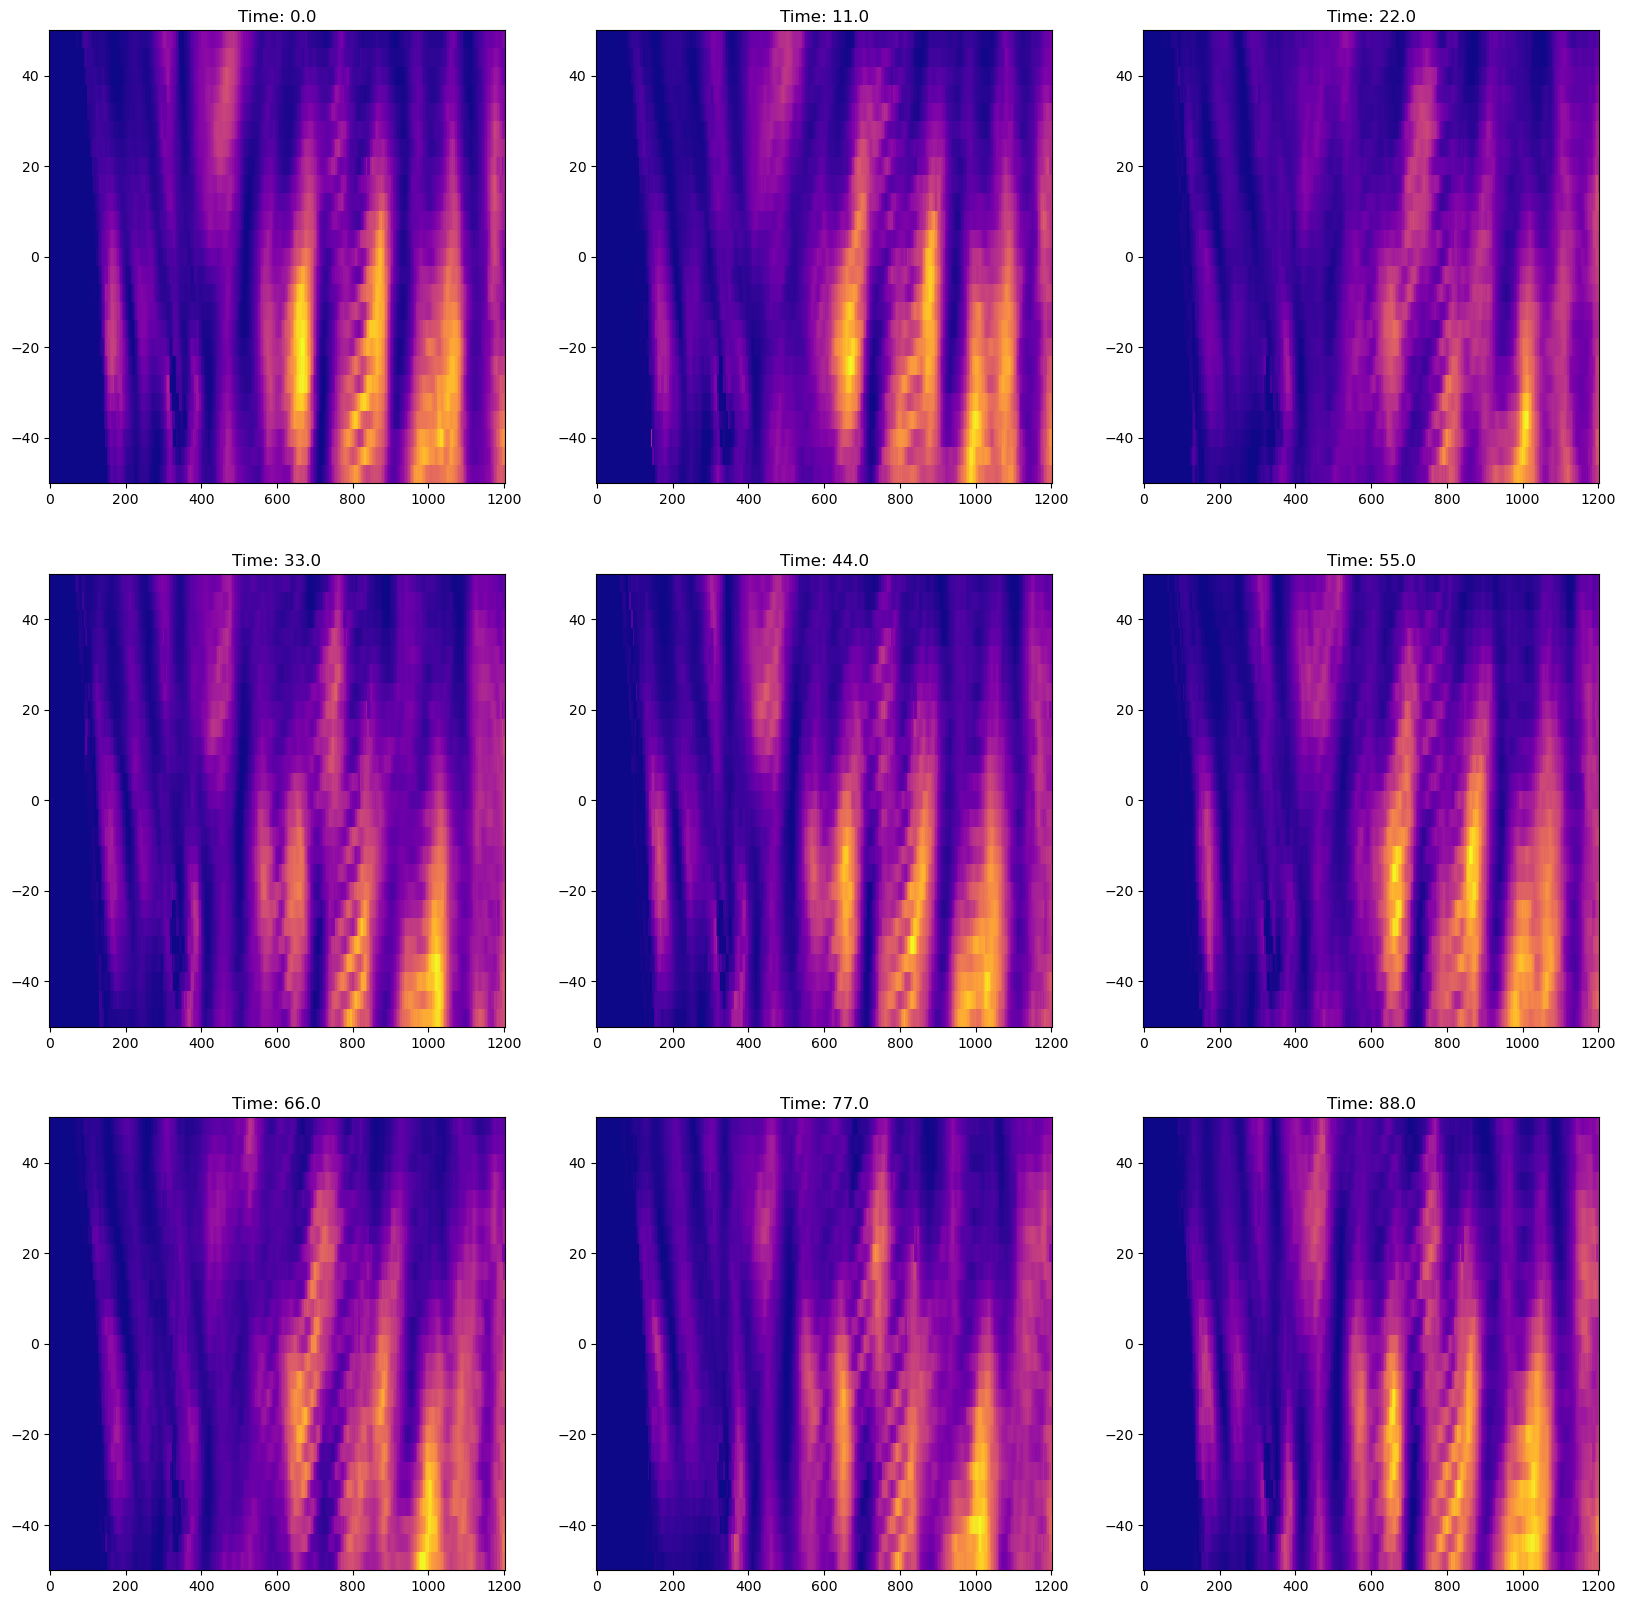

In [63]:
## Make a 3 by 3 grid of plots that increases in time selection as you read top left to bottom right
fig,ax = plt.subplots(3,3,figsize = (20,20))
times = np.linspace(0,99,10)
for i in range(3):
    for j in range(3):
        (vmodes.v**2 + vmodes.u**2).isel(time = int(times[i * 3 + j]),mode = 0).sel(xb = slice(0,1200)).plot(ax = ax[i,j],add_colorbar = False,cmap = "plasma")
        ax[i,j].set_title(f"Time: {times[i * 3 + j]}")
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")



In [12]:
for expt in to_process:
    print(expt)
    u = tt.VerticalModes(to_process[expt]["data"],"u").hztl
    v = tt.VerticalModes(to_process[expt]["data"],"v").hztl

    ## Now calculate the KE and integrate in time
    KE = 0.5 * ((u**2 + v**2)).mean("time").integrate("yb")
    to_process[expt]["KE"] = KE.load()


full-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


blank-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


ideal-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


smooth-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowd

Text(0.5, 0, '<-- Tassie  (km)  Macquarie Ridge -->')

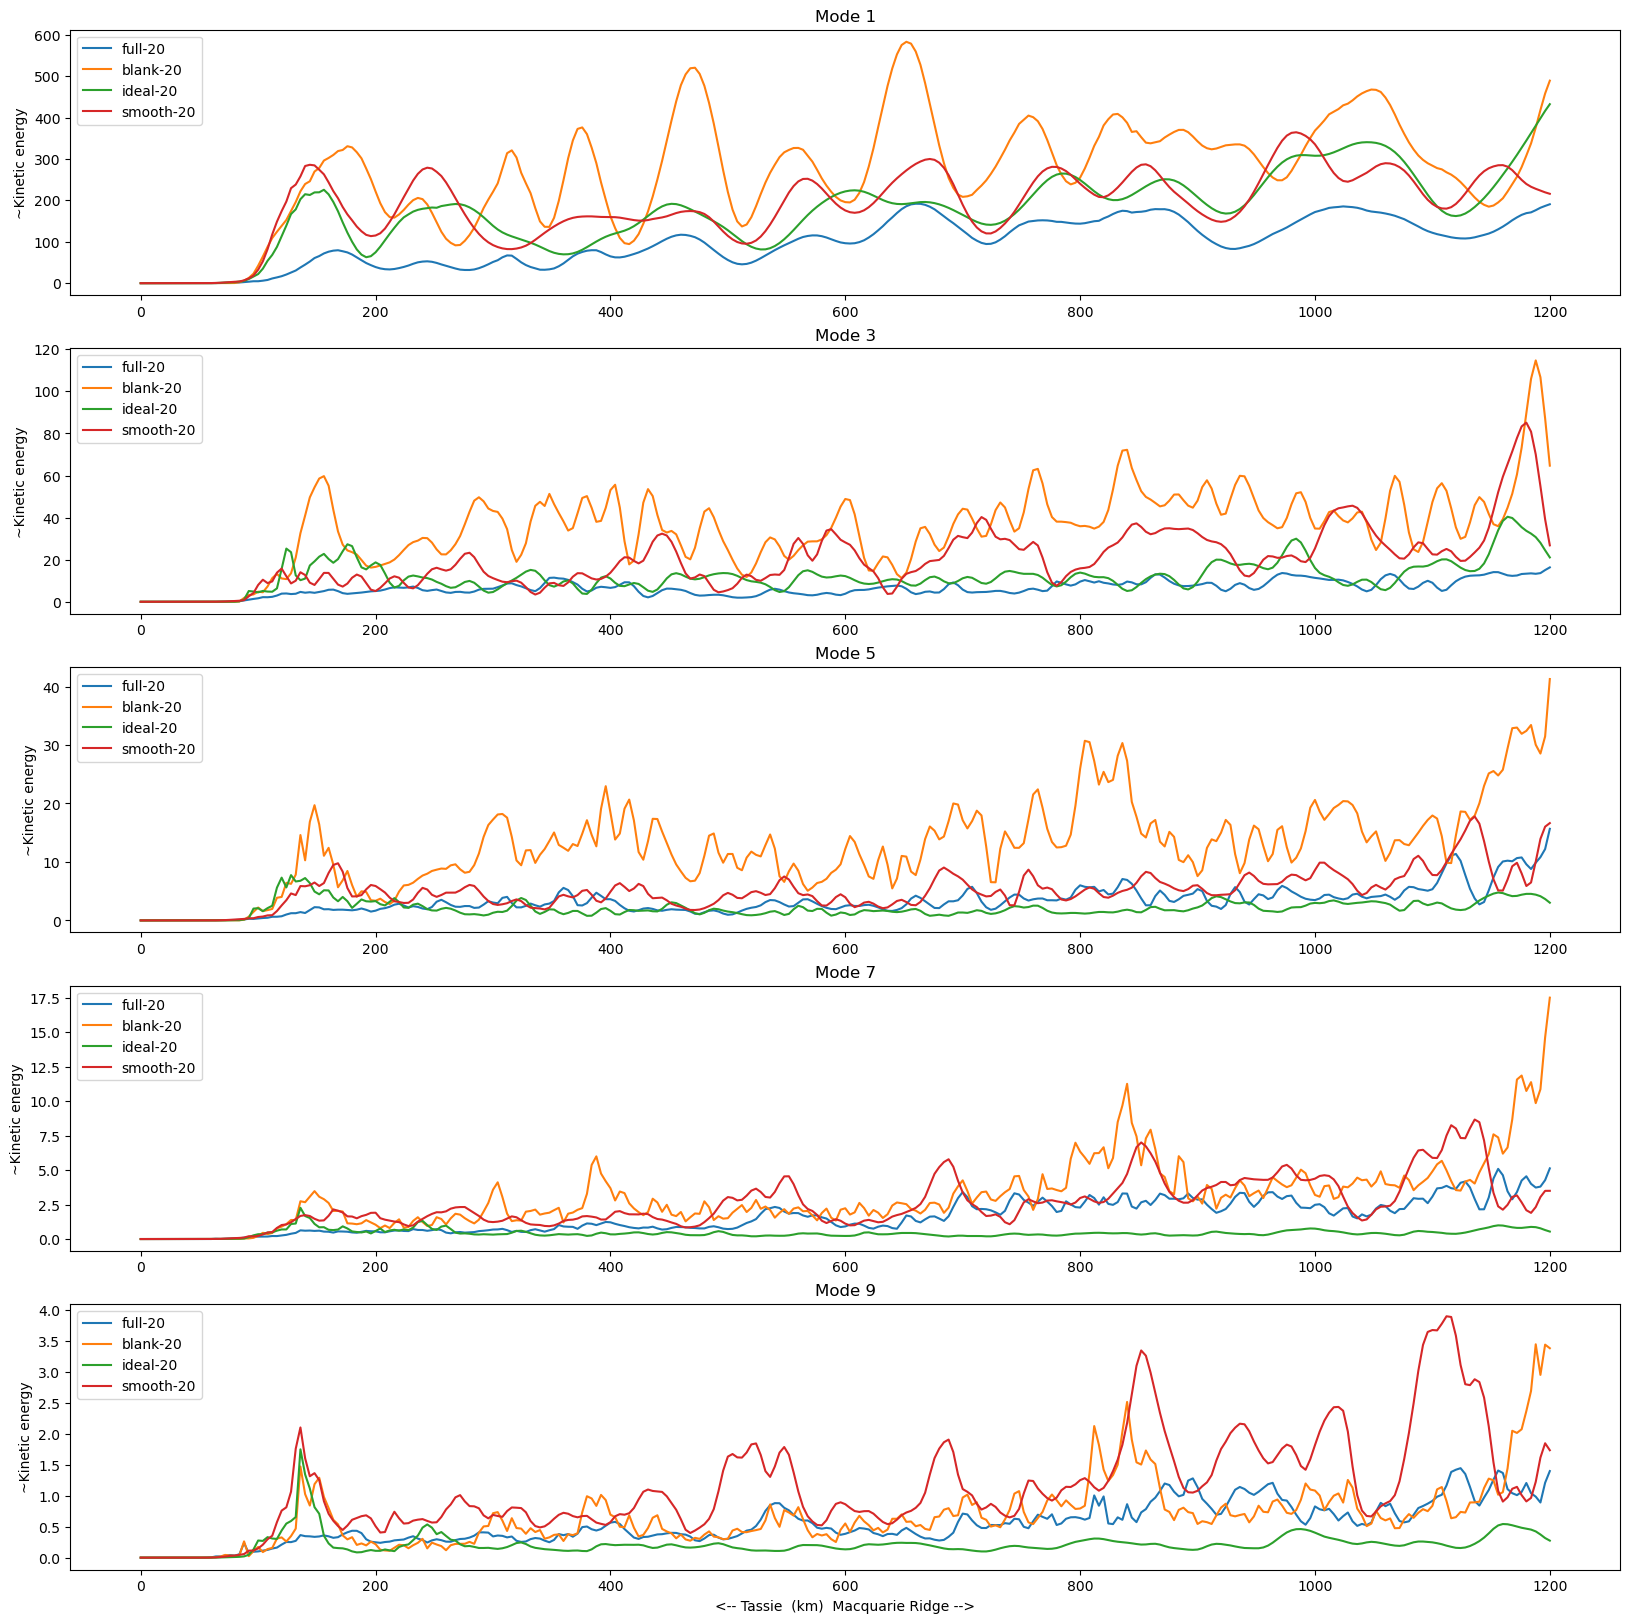

In [19]:
fig,ax = plt.subplots(5,figsize = (20,20))

for expt in to_process:
    for i,mode in enumerate(range(1,10,2)):
        to_process[expt]["KE"].mean("time").integrate("yb").isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i],label = expt)

        ax[i].set_title(f"Mode {mode}")


        ax[i].legend()
        ax[i].set_ylabel("~Kinetic energy")
        ax[i].set_xlabel("")



ax[-1].set_xlabel("<-- Tassie  (km)  Macquarie Ridge -->")


In [17]:
for expt in to_process:
    print(expt)
    u = tt.VerticalModes(to_process[expt]["data"],"u").hztl
    v = tt.VerticalModes(to_process[expt]["data"],"v").hztl

    ## Now calculate the KE and integrate in time
    KE = 0.5 * ((u**2 + v**2))
    to_process[expt]["KE"] = KE


full-20
blank-20
ideal-20
smooth-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


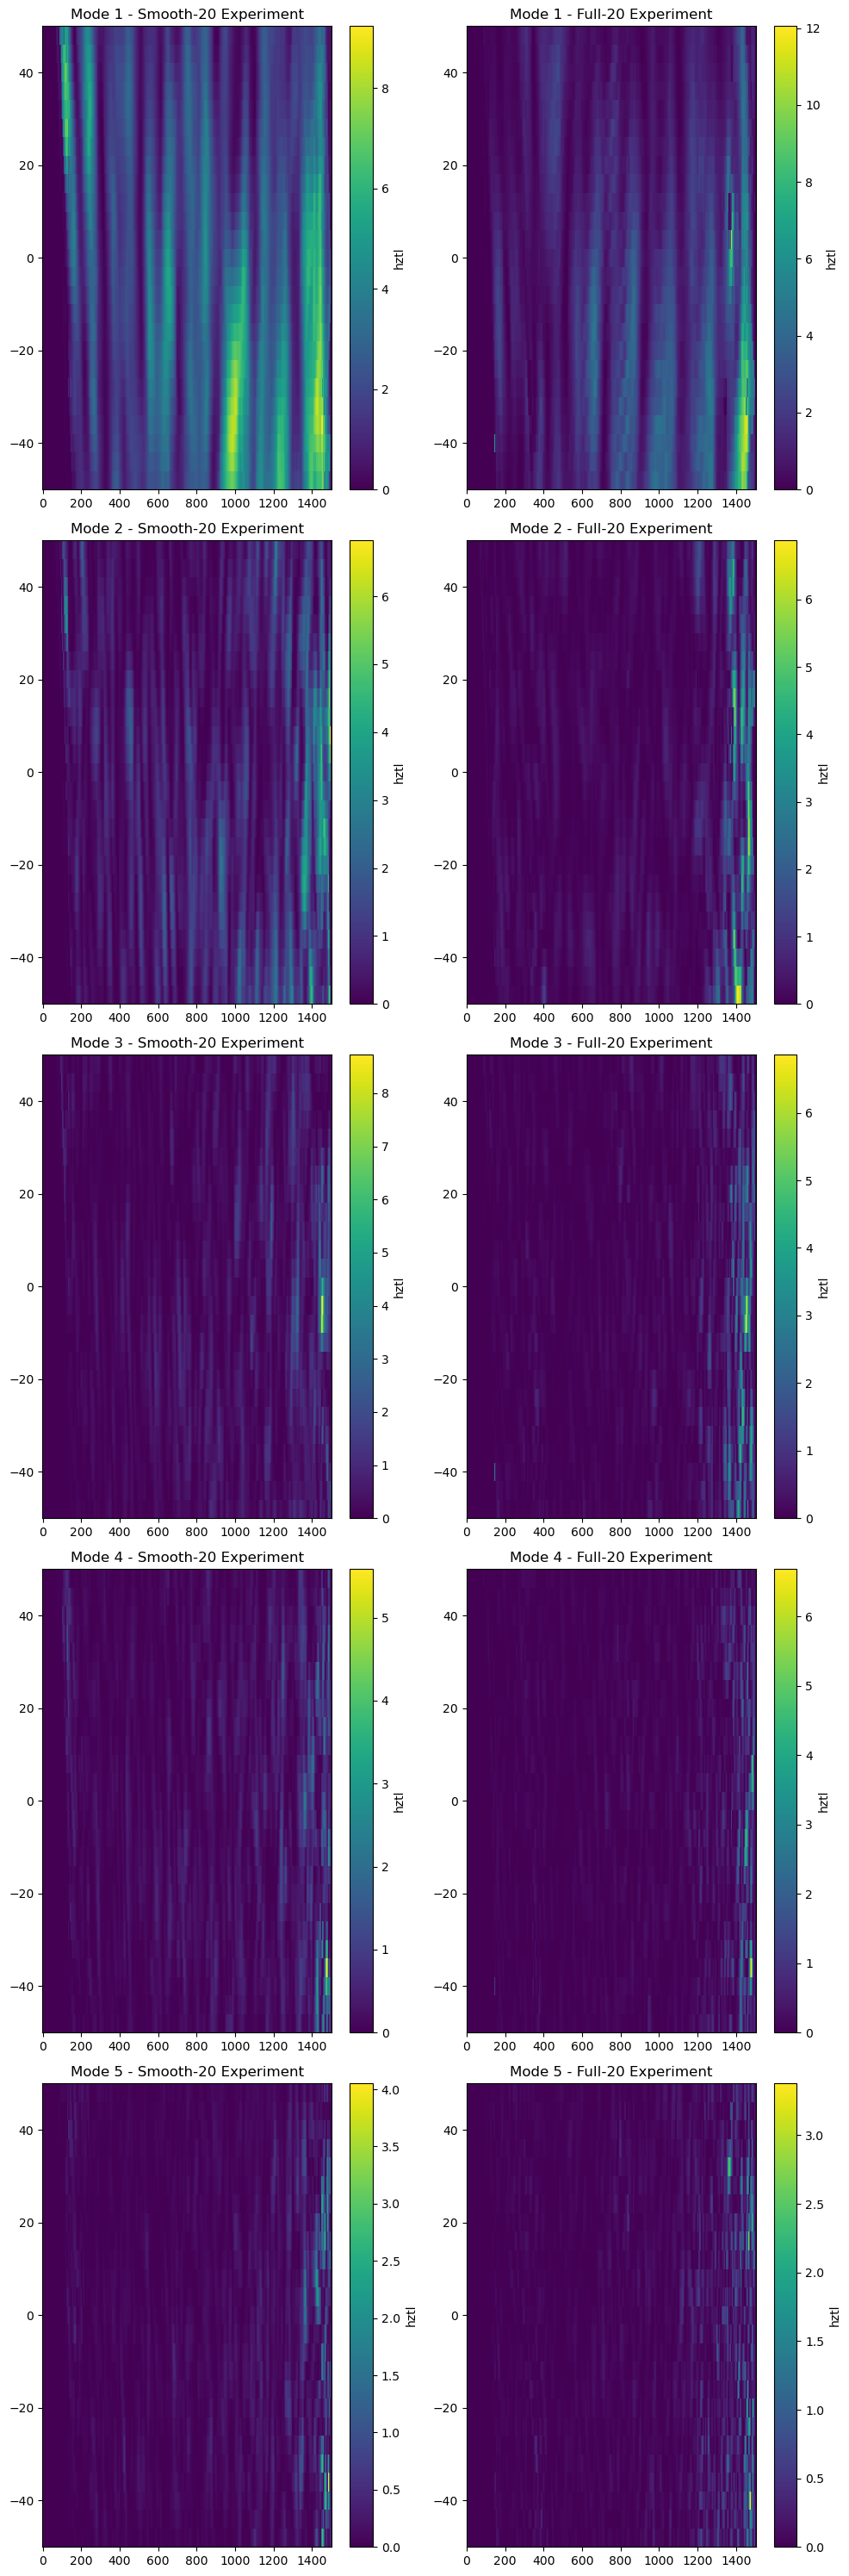

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(10, 30))

for i,mode in enumerate(range(1,6)):
    # Replace 'full_20_data[i]' and 'smooth_20_data[i]' with your actual data
    to_process["smooth-20"]["KE"].isel(mode = mode,time = 50).plot(ax = ax[i,0])
    to_process["full-20"]["KE"].isel(mode = mode,time = 50).plot(ax = ax[i,1])


    ax[i, 1].set_title(f'Mode {mode} - Full-20 Experiment')
    ax[i, 0].set_title(f'Mode {mode} - Smooth-20 Experiment')
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].set_xlabel("")

plt.tight_layout()
plt.show()

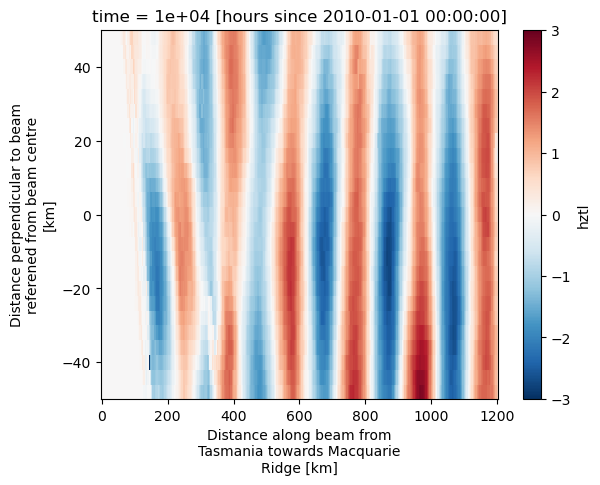

In [31]:
# u = tt.VerticalModes(to_process["full-20"]["data"],"u").hztl
u.isel(time = 50,mode = 1).sel(xb = slice(0,1200)).plot()

2024-05-25 23:10:16,850 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dc6bf84b9c814f782d9f801d733f5cce', 0),)


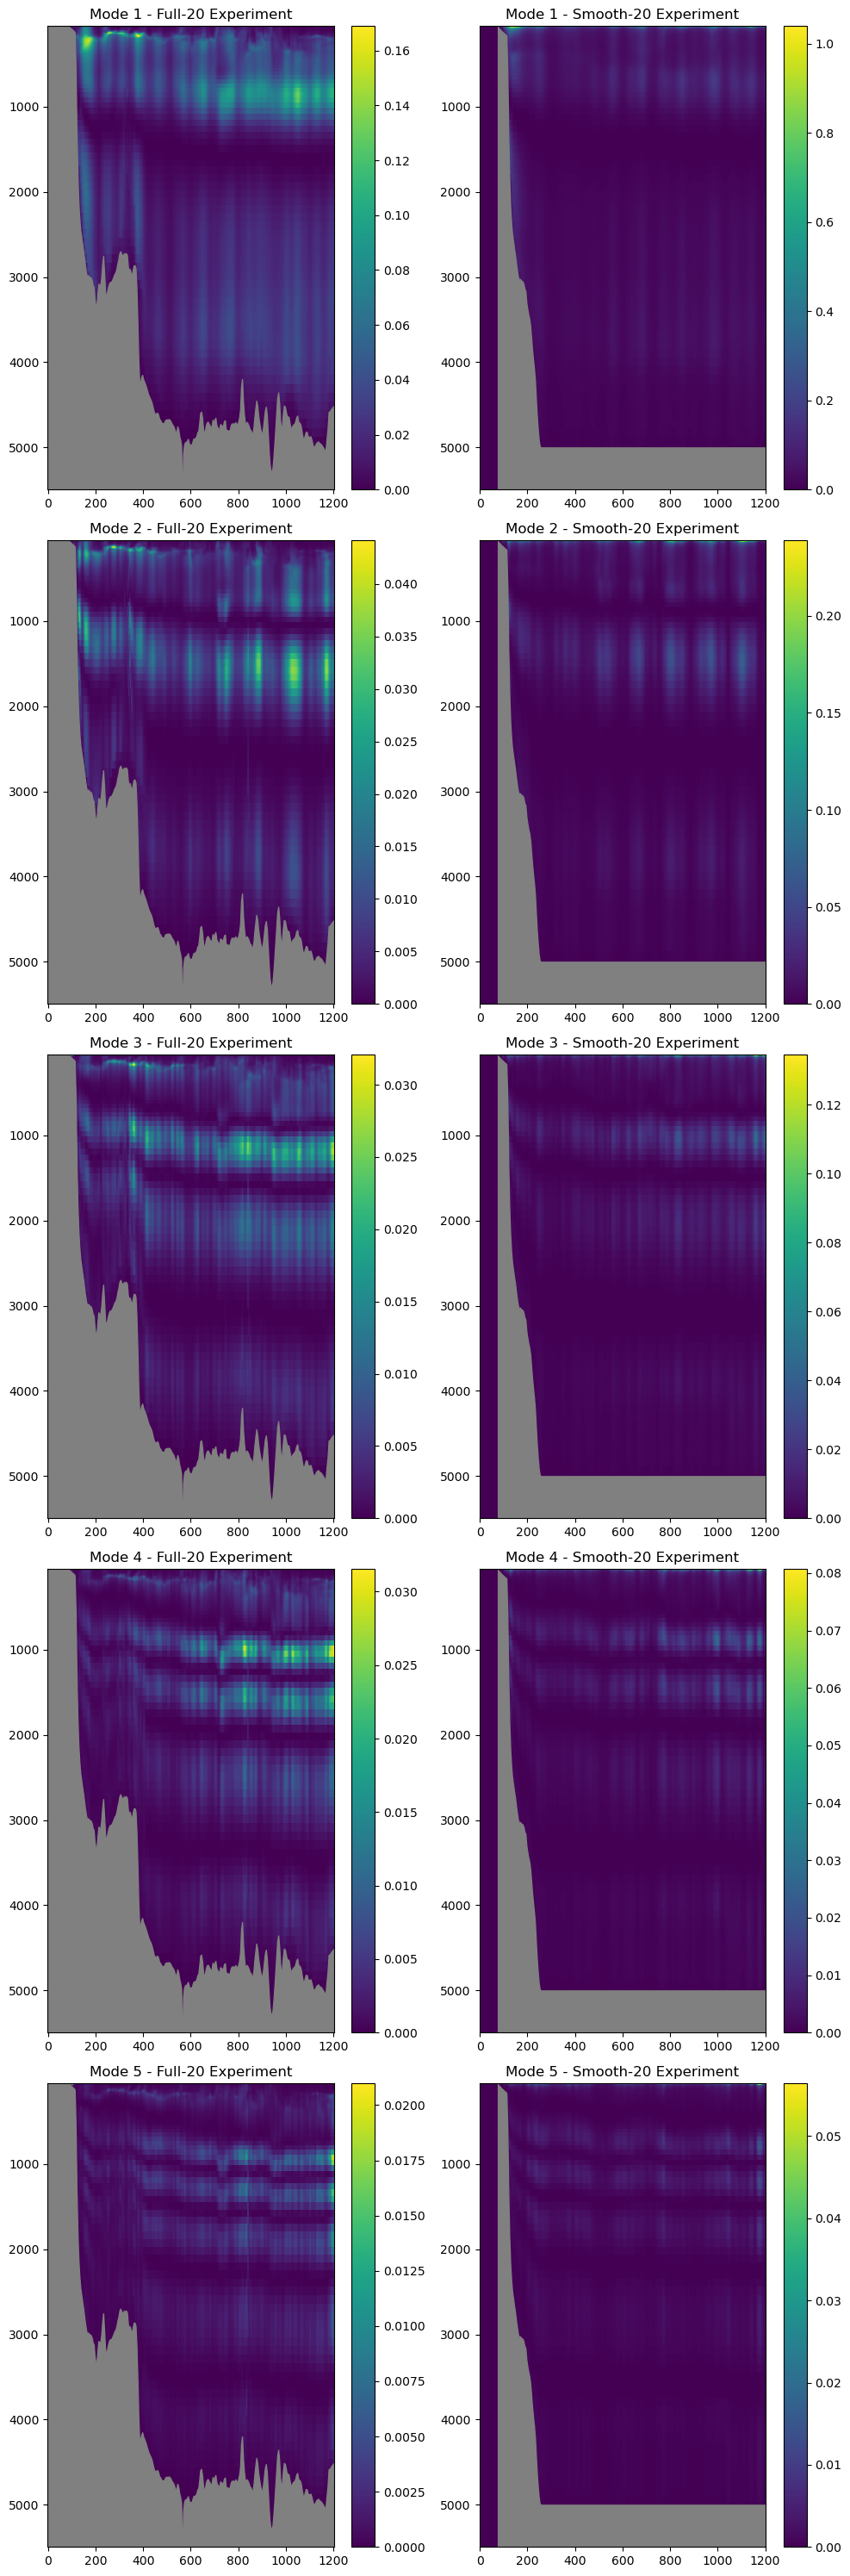

In [132]:
fig, ax = plt.subplots(5, 2, figsize=(10, 30))

for i,mode in enumerate(range(1,6)):
    # Replace 'full_20_data[i]' and 'smooth_20_data[i]' with your actual data
    to_process["full-20"]["KE"].isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i,0])
    to_process["smooth-20"]["KE"].isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i,1])
    ax[i,1].fill_between(
        to_process["smooth-20"]["data"].bathy.xb,
        to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
        6000,color = "gray"
    )
    ax[i,0].fill_between(
        to_process["full-20"]["data"].bathy.xb,
        -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
        6000,color = "gray"
    )

    ax[i,0].invert_yaxis()
    ax[i,1].invert_yaxis()
    ax[i, 0].set_title(f'Mode {mode} - Full-20 Experiment')
    ax[i, 1].set_title(f'Mode {mode} - Smooth-20 Experiment')
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].set_xlabel("")

plt.tight_layout()
plt.show()

## Smooth experiment has heightened velocities near surface??

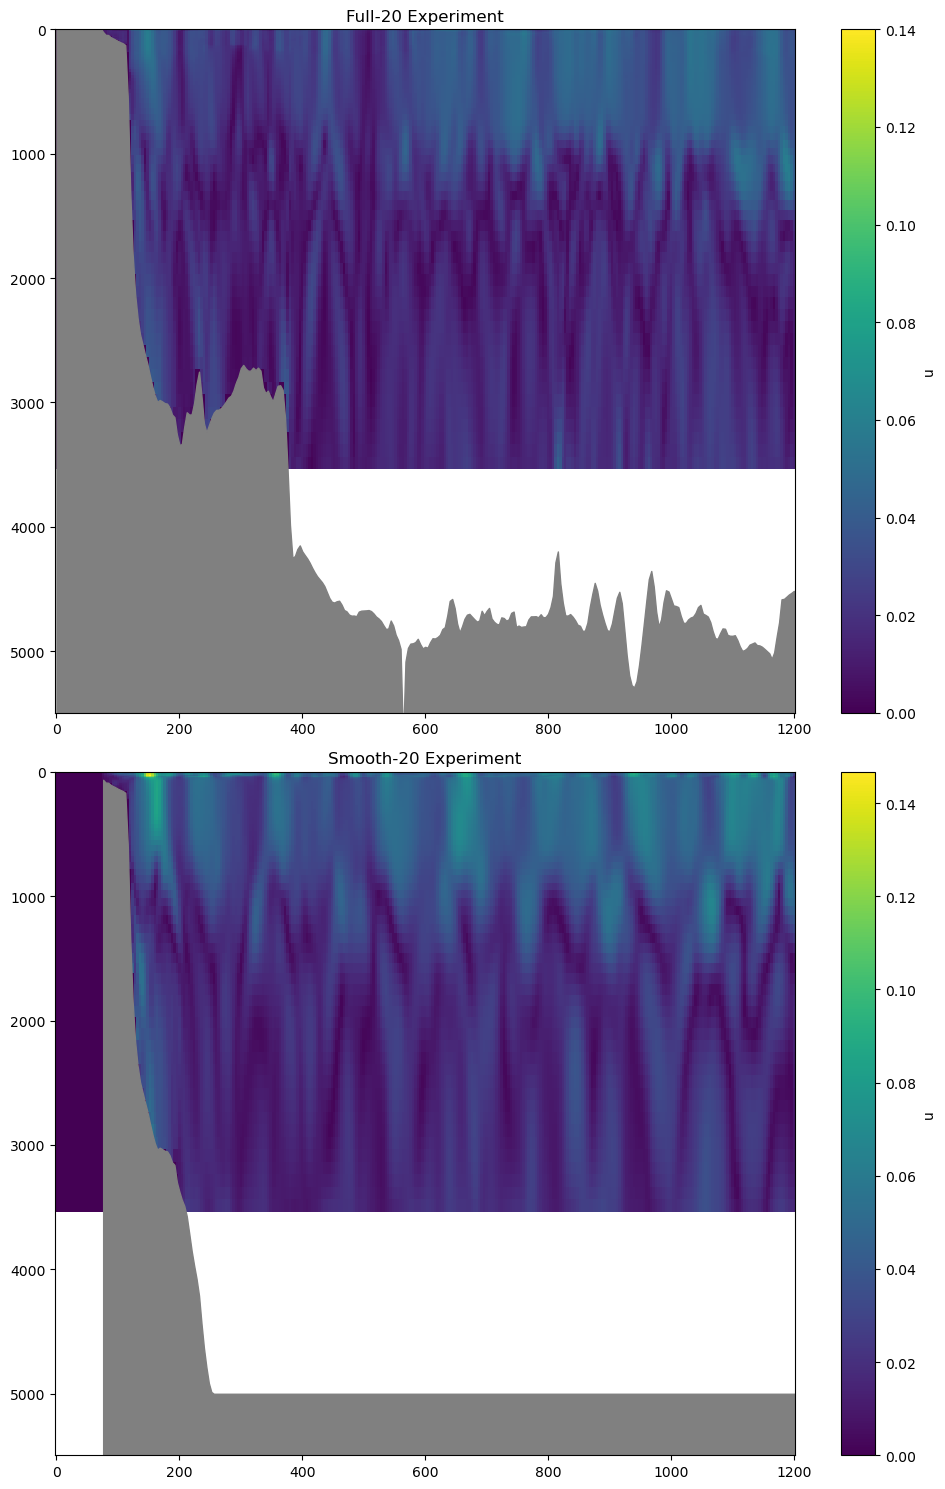

In [72]:
fig, ax = plt.subplots(2, figsize=(10, 15))


np.abs(to_process["full-20"]["data"].u).mean("time").sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[0],vmax = 0.14)
np.abs(to_process["smooth-20"]["data"].u).mean("time").sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[1])
ax[1].fill_between(
    to_process["smooth-20"]["data"].bathy.xb,
    to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)
ax[0].fill_between(
    to_process["full-20"]["data"].bathy.xb,
    -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title(f'Full-20 Experiment')
ax[1].set_title(f'Smooth-20 Experiment')
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Along Beam velocities at 50th layer down')

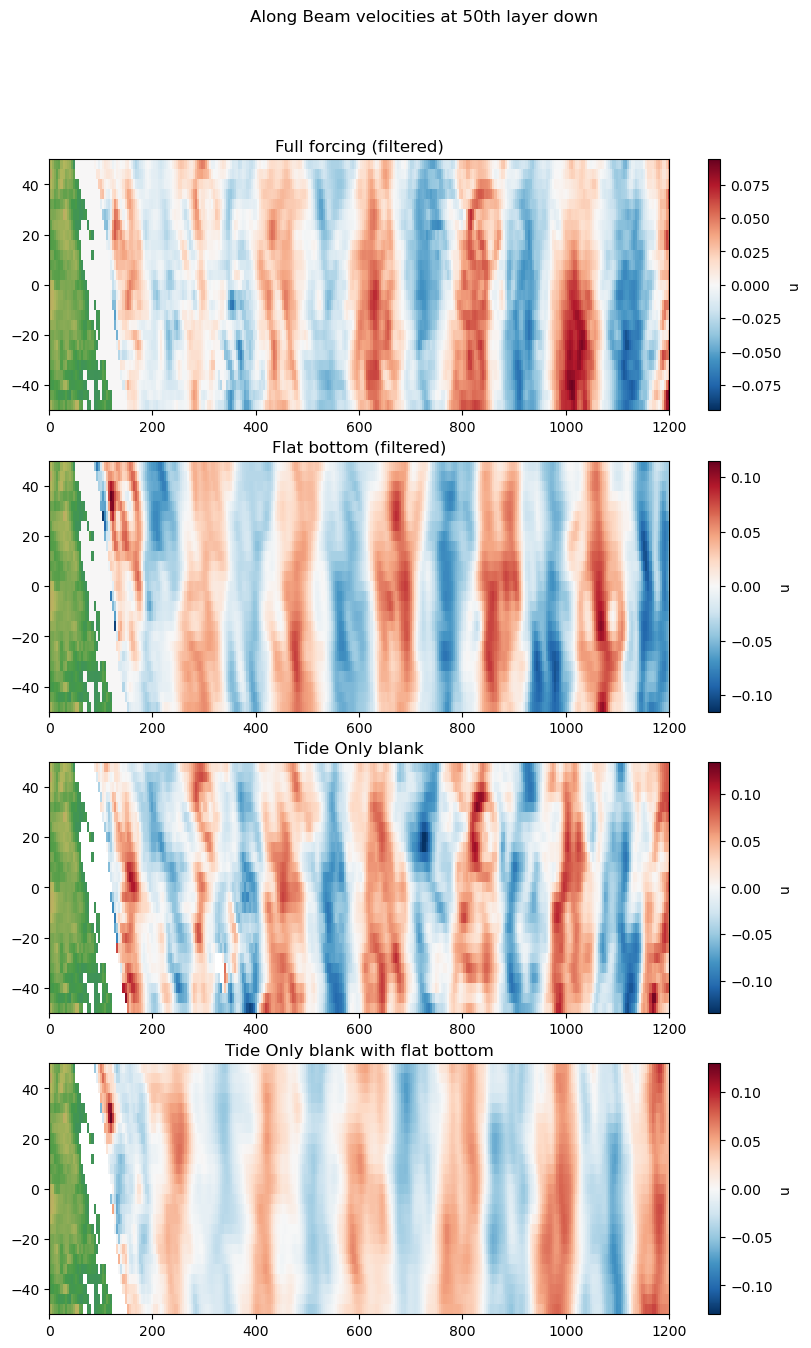

In [70]:
fig, ax = plt.subplots(4, figsize=(10, 15))


to_process["full-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[0])
to_process["smooth-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[1])
to_process["blank-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[2])
to_process["ideal-20"]["data"].u.isel(time = 5,zl = 50).sel(xb = slice(0,1200)).plot(ax = ax[3])
for i in range(4):
    tt.plot_topo(ax[i],to_process["full-20"]["data"].bathy)
    ax[i].set_xlim(0,1200)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
ax[0].set_title(f'Full forcing (filtered)')
ax[1].set_title(f'Flat bottom (filtered)')
ax[2].set_title(f'Tide Only blank')
ax[3].set_title(f'Tide Only blank with flat bottom')
# fig.suptitle("Along Beam velocities at surface")
fig.suptitle("Along Beam velocities at 50th layer down")


loading u...	done.
loading u...	done.


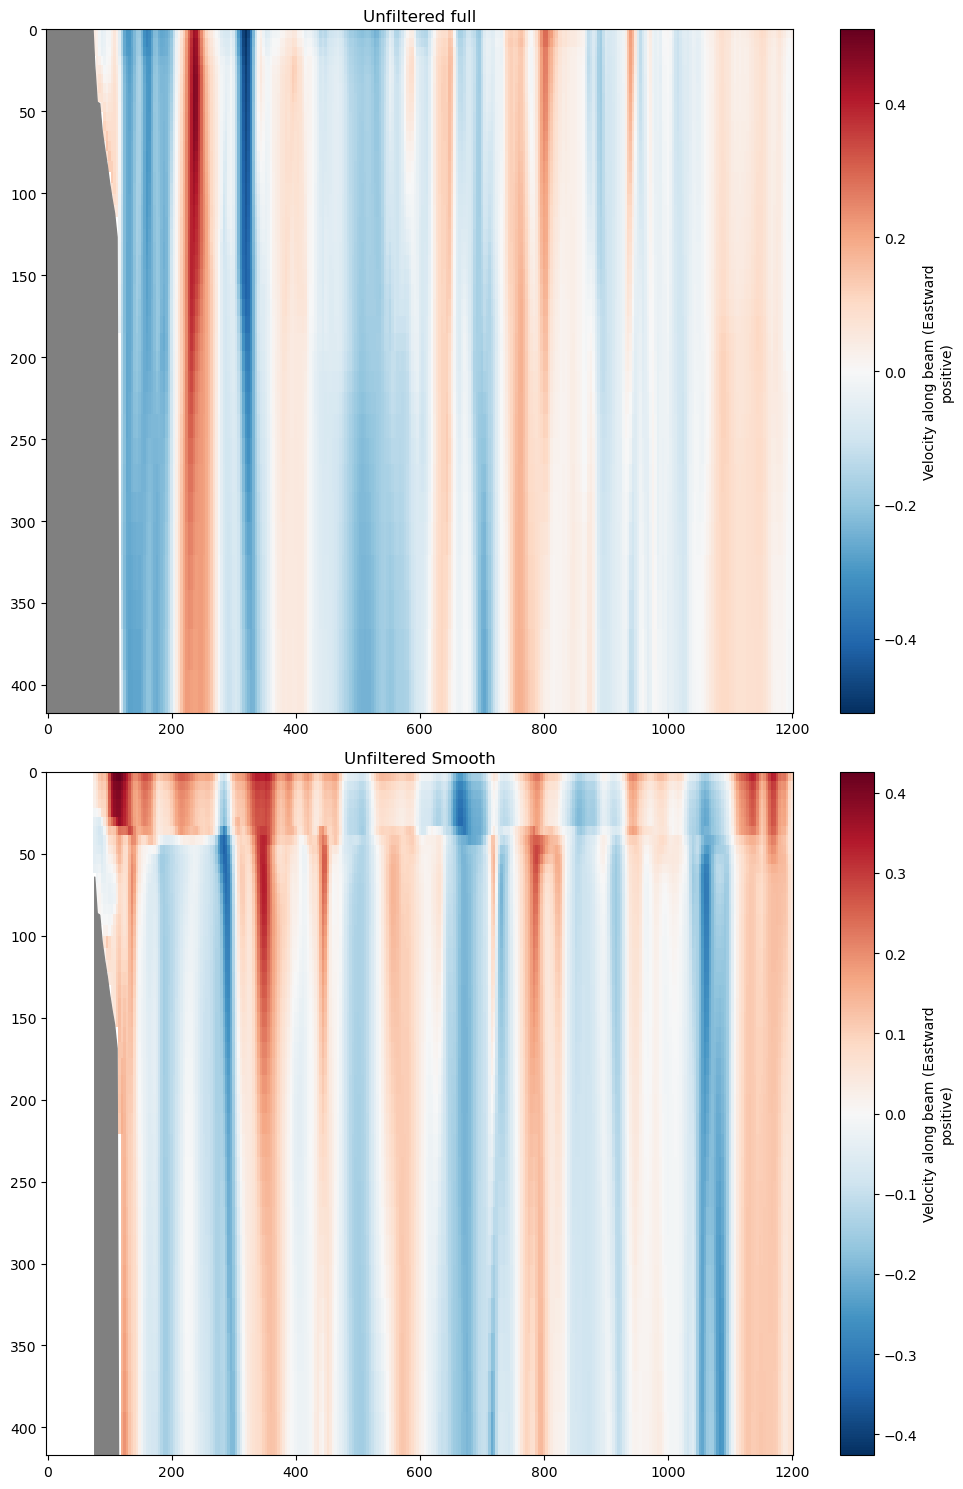

In [142]:
fig, ax = plt.subplots(2, figsize=(10, 15))
unfiltered_full = tt.collect_data("full-20",rawdata = ["u"],timerange = (40000-50,40000+50))
unfiltered_smooth = tt.collect_data("smooth-20",rawdata = ["u"],timerange = (10000-50,10000+50))

unfiltered_full.isel(time = 50,zl = slice(0,40)).u.sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[0])
unfiltered_smooth.isel(time = 50,zl = slice(0,40)).u.sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[1])
ax[1].fill_between(
    unfiltered_smooth.bathy.xb,
    unfiltered_smooth.bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)
ax[0].fill_between(
    unfiltered_full.bathy.xb,
    -1 * unfiltered_full.bathy.sel(yb = 0,method = "nearest"),
    6000,color = "gray"
)

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title(f'Unfiltered full')
ax[1].set_title(f'Unfiltered Smooth')
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

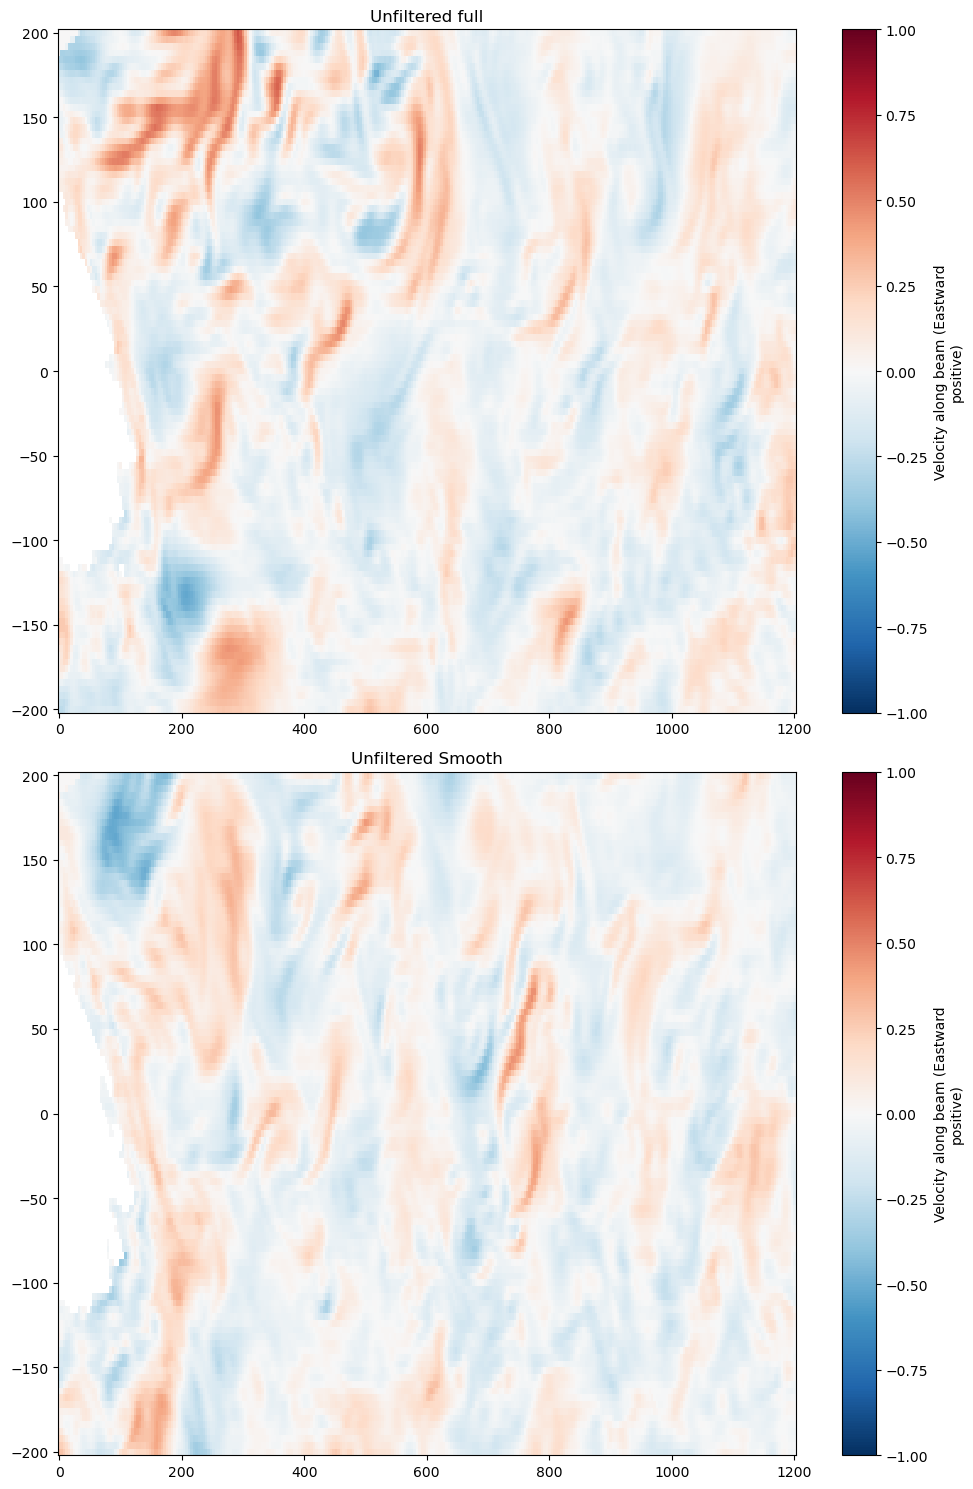

In [95]:
fig, ax = plt.subplots(2, figsize=(10, 15))

unfiltered_full.u.isel(time = 50).sel(zl = 50,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[0],vmax = 1)
unfiltered_smooth.u.isel(time = 50).sel(zl = 50,method = "nearest").sel(xb = slice(0,1200)).plot(ax = ax[1],vmax = 1)
# ax[1].fill_between(
#     to_process["smooth-20"]["data"].bathy.xb,
#     to_process["smooth-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
#     6000,color = "gray"
# )
# ax[0].fill_between(
#     to_process["full-20"]["data"].bathy.xb,
#     -1 * to_process["full-20"]["data"].bathy.sel(yb = 0,method = "nearest"),
#     6000,color = "gray"
# )

# ax[0].invert_yaxis()
# ax[1].invert_yaxis()
ax[0].set_title(f'Unfiltered full')
ax[1].set_title(f'Unfiltered Smooth')
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.
loading u...	done.


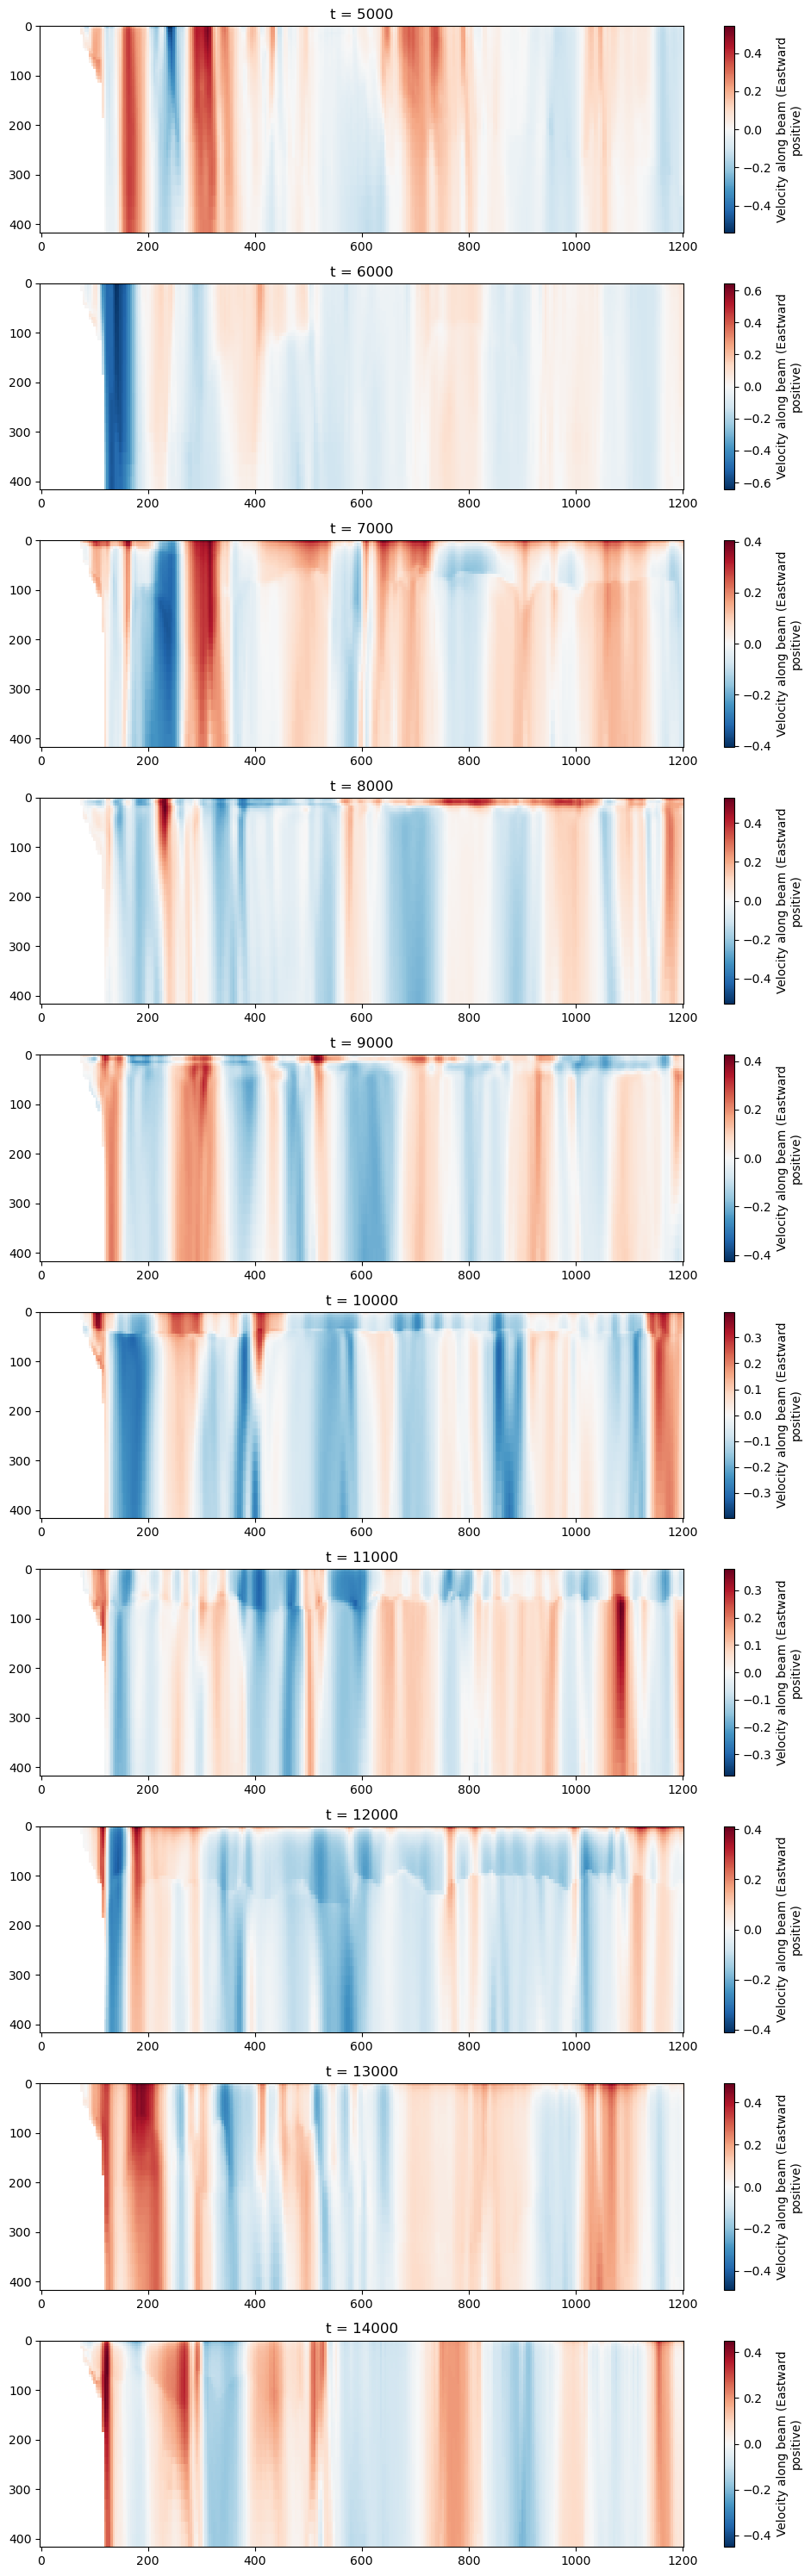

In [118]:
fig, ax = plt.subplots(10, figsize=(10, 30))

for i,j in enumerate(range(5000,15000,1000)):
    unfiltered_full = tt.collect_data("full-20",rawdata = ["u"],timerange = (j-50,j+50))
    unfiltered_full.isel(time = 50).u.sel(yb = 0,method = "nearest").sel(xb = slice(0,1200)).isel(zl = slice(0,40)).plot(ax = ax[i])
    # ax[i].fill_between(
    #     unfiltered_full.bathy.xb,
    #     -1 * unfiltered_full.bathy.sel(yb = 0,method = "nearest"),
    #     6000,color = "gray"
    # )
    ax[i].set_title(f"t = {j}")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

fig.tight_layout()


In [ ]:
(25 * 15)

In [126]:
print(5000 / (24 * 15))
print(10000 / (24 * 15))
print(4 * 15 * 0.88)
print(4 * 15 * 0.77)

13.88888888888889
27.77777777777778
52.8
46.2


Text(0.5, 0, '')

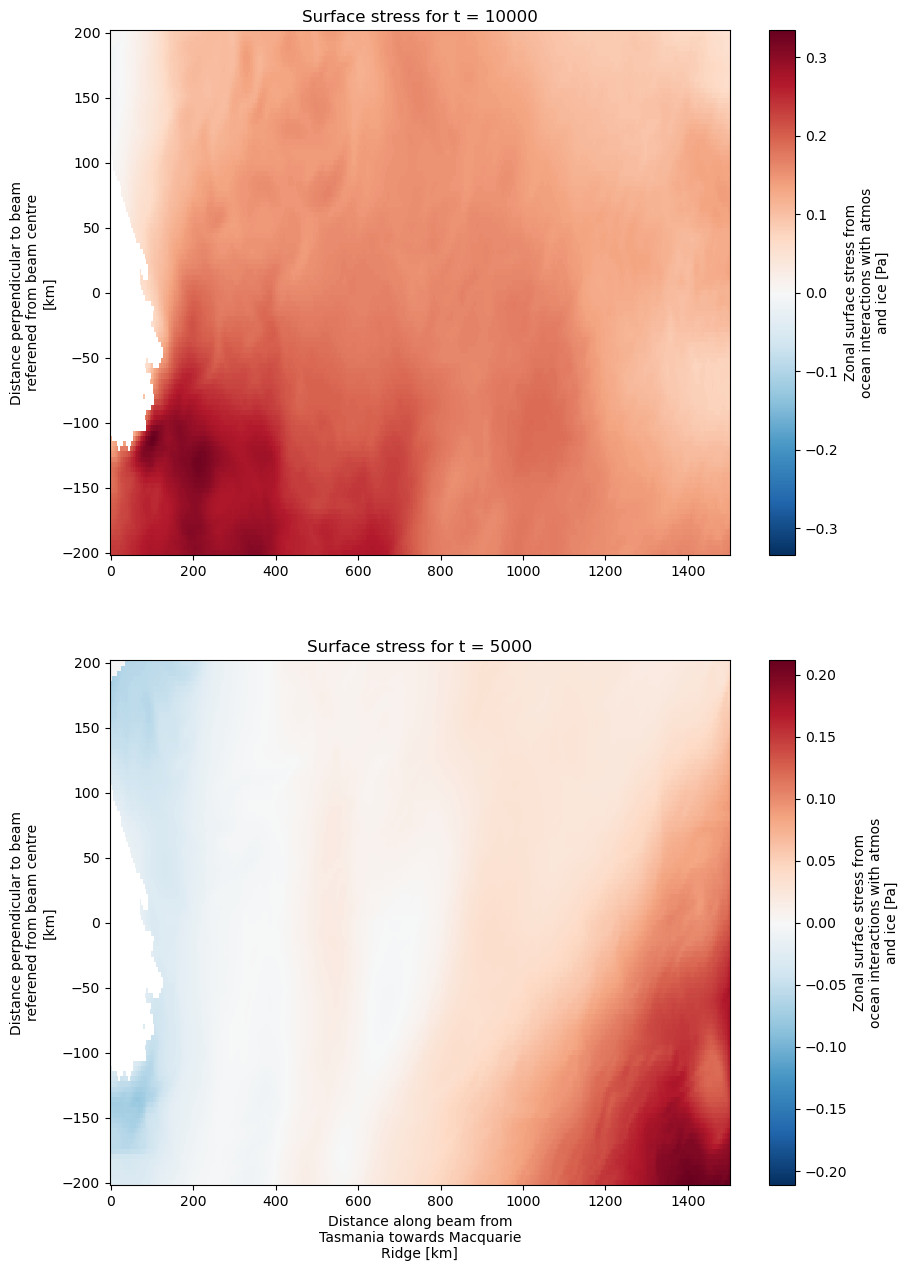

In [127]:
taux1 = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/full-20/output027/surface_transect.nc",decode_times = False)
taux2 = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/full-20/output013/surface_transect.nc",decode_times = False)

# plot both of these
fig, ax = plt.subplots(2, figsize=(10, 15))
taux1.taux.isel(time = 46).plot(ax = ax[0])
taux2.taux.isel(time = 53).plot(ax = ax[1])

ax[0].set_title(f"Surface stress for t = 10000")
ax[1].set_title(f"Surface stress for t = 5000")
ax[0].set_xlabel(f"")
